In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score, roc_curve

In [46]:
df=pd.read_csv('breast cancer dataset.csv').drop(["Unnamed: 32","id"],axis = 1)

In [48]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [52]:
df.groupby(["diagnosis"])['diagnosis'].value_counts()
# Almost no imbalance

diagnosis
B    357
M    212
Name: count, dtype: int64

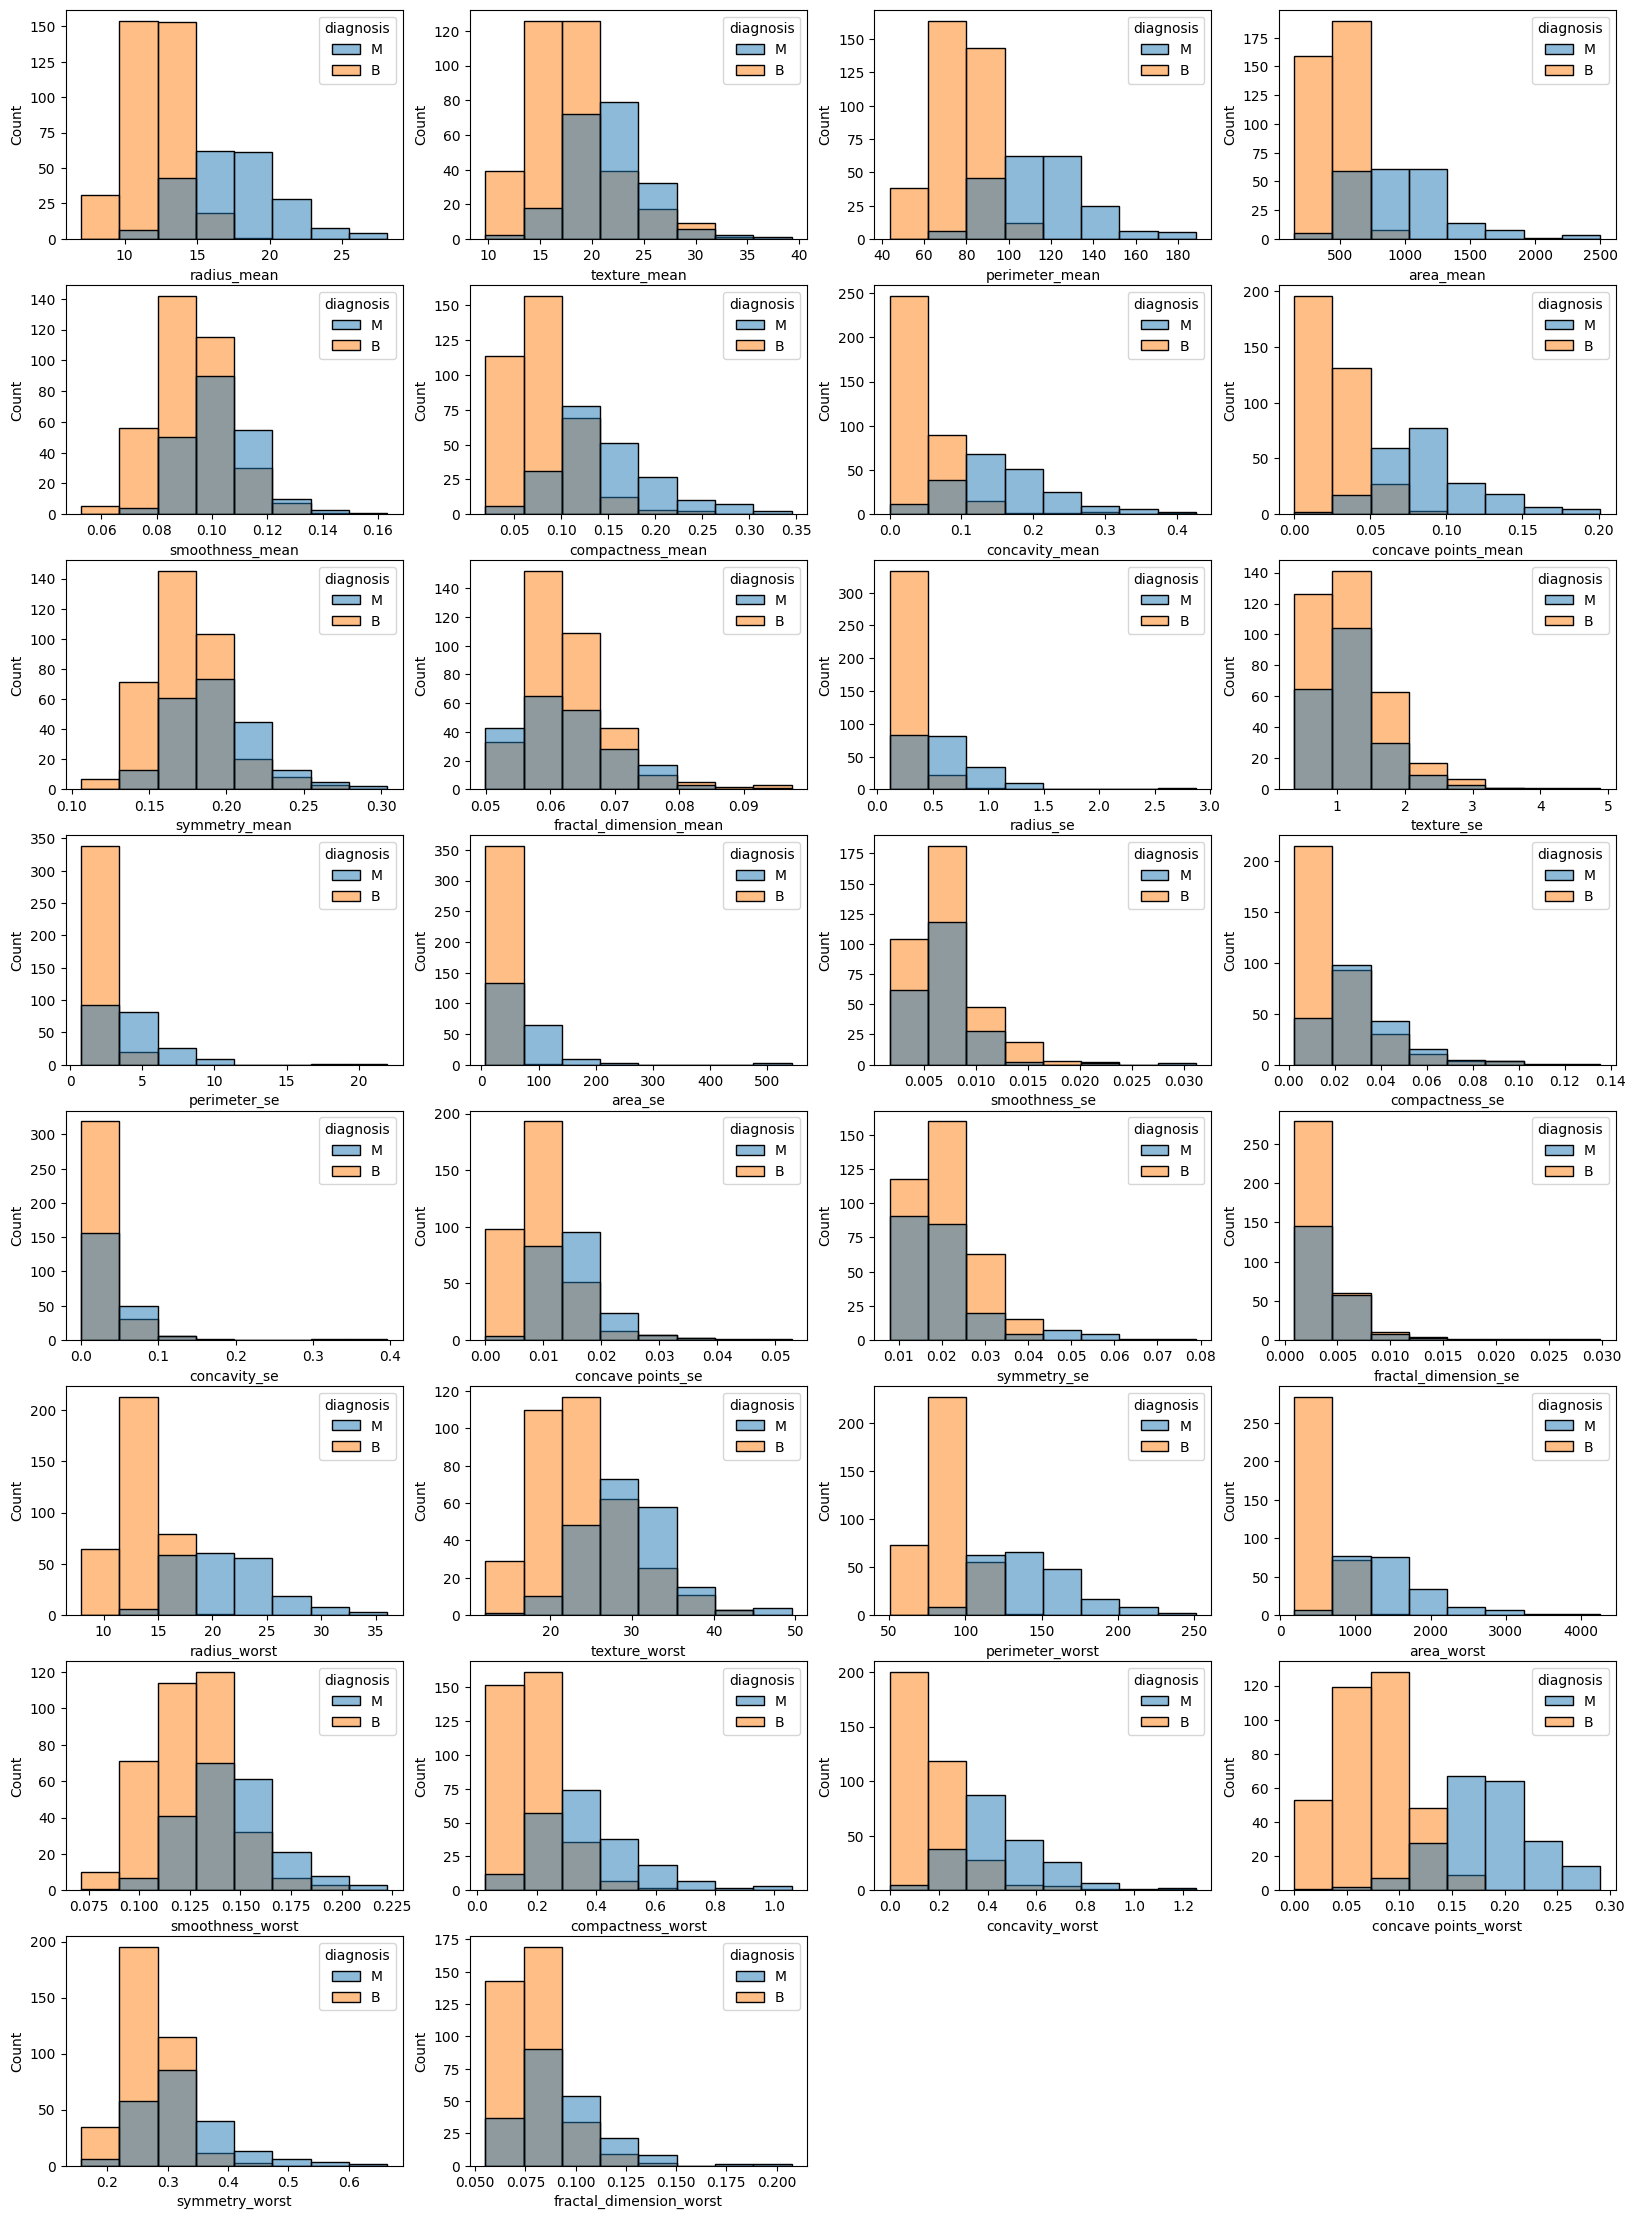

In [54]:
plt.figure(figsize=(20,28))
columns = df.columns
for i,label in enumerate(columns[1:]):
    plt.subplot(8,4,i+1)
    sns.histplot(data=df,x=label,hue="diagnosis",bins=8)
plt.show()

In [55]:
# diagnosis M == 1, B == 0
df['diagnosis']=(df["diagnosis"] == 'M').astype(int)

In [56]:
Y = df["diagnosis"]

In [57]:
X = df.drop(["diagnosis"],axis = 1)

In [58]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.8,random_state=44)

In [59]:
X_train_PCA_manual = X_train.drop(["texture_se","smoothness_se","fractal_dimension_mean"],axis = 1);
X_test_PCA_manual = X_test.drop(["texture_se","smoothness_se","fractal_dimension_mean"],axis = 1);

In [60]:
models = {
    "Logistic Regression": {
        "pipeline": Pipeline([("scaler", StandardScaler()),("LogisticRegression",LogisticRegression())]),
        "params": {"LogisticRegression__C": [0.01, 0.1, 1, 10]}
    },"SVC":{
        "pipeline":Pipeline([("scaler", StandardScaler()),("SVC",SVC(probability=True,kernel="linear"))]),
        "params":{"SVC__C": [0.1, 1, 10],}
    }
        }

In [61]:
models_grid={}
for name,config in models.items():
    grid = GridSearchCV(config["pipeline"], config["params"], scoring="roc_auc", cv=5)
    grid.fit(X_train_PCA_manual, Y_train)
    print(grid.best_params_)
    models_grid[name]=grid

{'LogisticRegression__C': 0.1}
{'SVC__C': 0.1}


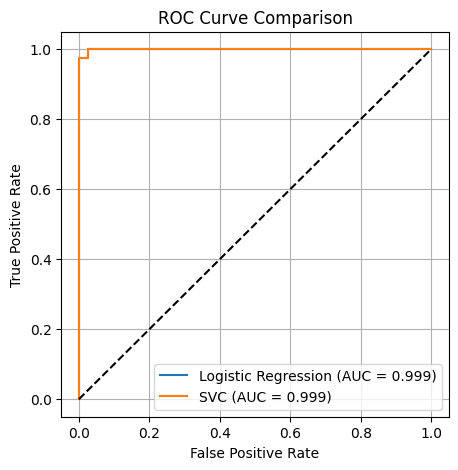

In [62]:
plt.figure(figsize=(5,5))
for name in models_grid:
    y_proba = models_grid[name].predict_proba(X_test_PCA_manual)[:, 1]
    fpr, tpr, _ = roc_curve(Y_test, y_proba)
    auc_score = roc_auc_score(Y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')
    plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()

In [63]:
Lr = models_grid["Logistic Regression"]
Lr.fit(X_train_PCA_manual,Y_train)
Y_pred_Lr=Lr.predict(X_test_PCA_manual)
report=classification_report(Y_test,Y_pred_Lr)
cross_validation_score=np.average(cross_val_score(Lr,X_train_PCA_manual,Y_train.values.ravel(),n_jobs=-1,cv=5))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        75
           1       1.00      0.97      0.99        39

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



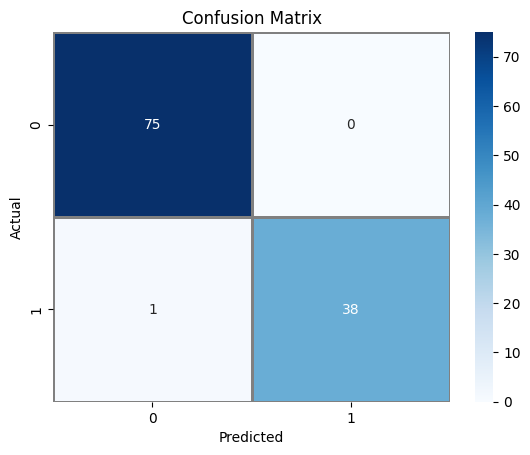

In [65]:
print(report)
sns.heatmap(confusion_matrix(Y_test,Y_pred_Lr),annot=True, fmt='d', cmap='Blues',linewidths=1,linecolor='grey')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()